In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

# import warnings

# warnings.filterwarnings("ignore")
# import logging

# logging.disable(logging.CRITICAL)

In [3]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

## example of `passenger` dataset

In [ ]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

In [ ]:
series.plot()

In [ ]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)


In [ ]:
series_transformed = transformer.transform(series)

In [ ]:
# create year, month and integer index covariate series

covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)

covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

In [ ]:
covariates["month"].plot()

In [ ]:
covariates["year"].plot()

In [ ]:
covariates.columns

In [ ]:
covariate_values = covariates.values()

In [ ]:
type(covariate_values)

In [ ]:
covariate_values[:20]

In [ ]:
covariates.width

In [ ]:
covariates.time_index

In [ ]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# define quantiles

quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

In [ ]:
# window setting

input_chunk_length = 24
forecast_horizon = 12

In [ ]:
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [ ]:
my_model.fit(
    train_transformed, 
    future_covariates=covariates_transformed, 
    verbose=True)

In [ ]:
series_transformed.end_time()

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

In [ ]:
eval_model(my_model, 24, series_transformed, val_transformed)

## example of `Monthly ice cream sales` dataset

In [4]:
series_ice_heater = IceCreamHeaterDataset().load()

In [5]:
series_ice_heater.columns

Index(['heater', 'ice cream'], dtype='object', name='component')

In [6]:
series_ice_heater.width

2

<Axes: xlabel='Month'>

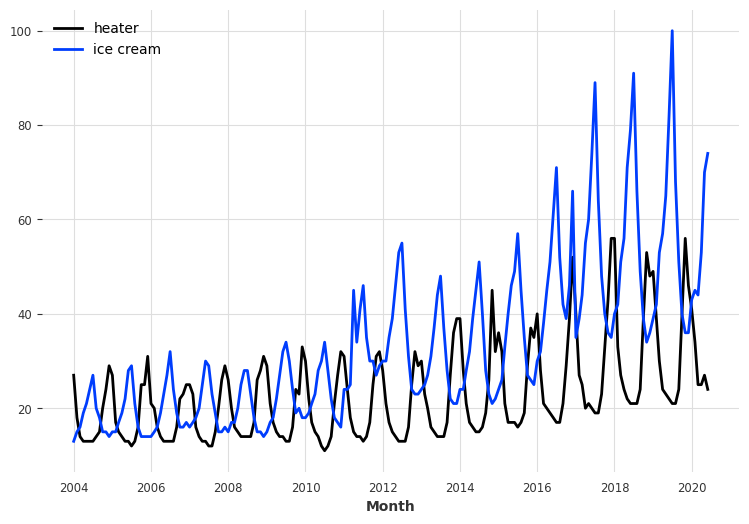

In [7]:
plt.figure(figsize=figsize)
series_ice_heater.plot()

In [8]:
series_ice_heater.time_index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='Month', length=198, freq='MS')

In [11]:
len(series_ice_heater)

198

### preprocessing

In [12]:
# convert monthly sales to average daily sales per month
converted_series = []
for col in ["ice cream", "heater"]:
    converted_series.append(
        series_ice_heater[col]
        / TimeSeries.from_series(series_ice_heater.time_index.days_in_month)
    )
converted_series = concatenate(converted_series, axis=1)

In [15]:
# print(converted_series)
len(converted_series)

198

In [16]:
# manually select a portion of data for simplicity
converted_series = converted_series[pd.Timestamp("20100101") :]

In [17]:
len(converted_series)

126

In [18]:
# split the data

# define train/validation cutoff time
forecast_horizon_ice = 12
training_cutoff_ice = converted_series.time_index[-(2 * forecast_horizon_ice)]

In [19]:
training_cutoff_ice

Timestamp('2018-07-01 00:00:00')

In [20]:
# scale the data

# use ice cream sales as target, create train and validation sets and transform data
series_ice = converted_series["ice cream"]
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)
transformer_ice = Scaler()
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(series_ice)

# use heater sales as past covariates and transform data
covariates_heat = converted_series["heater"]
cov_heat_train, cov_heat_val = covariates_heat.split_before(training_cutoff_ice)
transformer_heat = Scaler()
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(covariates_heat)

### modelling

In [21]:
# use the last 3 years as past input data
input_chunk_length_ice = 36

In [22]:
# use `add_encoders` as we don't have future covariates
my_model_ice = TFTModel(
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

In [23]:
# fit the model with past covariates
my_model_ice.fit(
    train_ice_transformed, past_covariates=covariates_heat_transformed, verbose=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.9 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.9 K 
6  | static_context_grn                | _GatedResidualNetwork            | 4.3 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 4.3 K 
8  | static_cont

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=300` reached.


TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)